In [1]:
%matplotlib inline

In [2]:
import emcee
import autograd.numpy as np
import matplotlib.pyplot as plt
from astropy.stats import LombScargle, median_absolute_deviation
from scipy.optimize import minimize
import glob
from tqdm import tqdm

import celerite
from celerite import terms

from gp import get_rotation_gp
from astropy.io import fits

do_kep = True

In [3]:
t, y, yerr = np.genfromtxt('example_star.csv', delimiter=',', unpack=True)
name = 'example'

if do_kep:
    f = fits.open('../data/kplr009726699-2010203174610_slc.fits') 
    hdu_data = f[1].data
    fin = np.isfinite(hdu_data["sap_flux"]*hdu_data["sap_flux_err"])

    t = hdu_data["time"][fin]
    y = hdu_data["sap_flux"][fin]/np.nanmedian(hdu_data["sap_flux"])
    yerr = hdu_data["sap_flux_err"][fin]/np.nanmedian(hdu_data["sap_flux"])

    ninc = 5000
    rand = np.random.randint(0,len(t)-ninc)
    t = t[rand:rand+ninc]
    y = y[rand:rand+ninc]
    yerr = yerr[rand:rand+ninc]

    name = f[0].header['OBJECT'].replace(' ','')


In [4]:
# Do some aggressive sigma clipping
m = np.ones(len(t), dtype=bool)
while True:
    mu = np.mean(y[m])
    sig = np.std(y[m])
    m0 = y - mu < 3 * sig
    if np.all(m0 == m):
        break
    m = m0

t_orig, y_orig, yerr_orig = np.copy(t), np.copy(y), np.copy(yerr)
t, y, yerr = t[m], y[m], yerr[m]

0.590933270287842


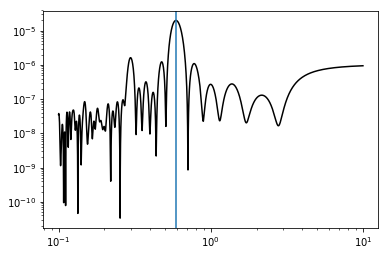

In [5]:
# First guess at the period
freq = np.linspace(0.1, 10.0, 5000)
model = LombScargle(t, y)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)

period = 1.0 / freq[np.argmax(power)]
print(period)

plt.plot(1.0 / freq, power, "k")
plt.axvline(period)
plt.xscale("log")
plt.yscale("log")

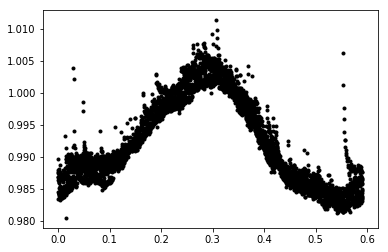

In [6]:
plt.plot(t % period, y, ".k")

In [7]:
t, y, yerr = t_orig, y_orig, yerr_orig
min_period = period * 0.7
max_period = period / 0.7

gp = get_rotation_gp(t, y, yerr, period, min_period, max_period)

initial_params = gp.get_parameter_vector()
# log_a, logQ1, mix_par, logQ2, log_P

gp.compute(t, yerr)
print(gp.log_likelihood(y))
gp.get_parameter_dict()

-70876.7763874


OrderedDict([('kernel:terms[0]:log_S0', -9.99376392364502),
             ('kernel:terms[0]:log_omega0', -0.46470802658470023),
             ('kernel:terms[1]:log_sigma', -8.192930221557617),
             ('kernel:terms[2]:log_a', -9.99376392364502),
             ('kernel:terms[2]:log_Q1', 2.70805020110221),
             ('kernel:terms[2]:mix_par', -1.0),
             ('kernel:terms[2]:log_Q2', 2.70805020110221),
             ('kernel:terms[2]:log_P', -0.5260521777852807)])

In [8]:
def neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y[m])

def grad_neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y[m])[1]

# Do another round of sigma clipping using the GP model
bounds = gp.get_parameter_bounds()
m = np.ones(len(t), dtype=bool)
for i in range(10):
    gp.compute(t[m], yerr[m])
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(y, gp, m))
    gp.set_parameter_vector(soln.x)
#     print(soln)
    initial_params = soln.x
    # log_a, logQ1, mix_par, logQ2, log_P
#     print(initial_params)
    mu, var = gp.predict(y[m], t, return_var=True)
    sig = np.sqrt(var + yerr**2)
    
    m0 = y - mu < 1.3 * sig
    print(m0.sum(), m.sum())
    if np.all(m0 == m) or (np.abs(m0.sum()- m.sum()) < 3):
        break
    m = m0
    
fit_t, fit_y, fit_yerr = t[m], y[m], yerr[m]

gp.compute(fit_t, fit_yerr)
gp.log_likelihood(fit_y)   
gp.get_parameter_dict()

(4558, 5000)
(4114, 4558)
(3905, 4114)
(3793, 3905)
(3725, 3793)
(3667, 3725)
(3604, 3667)
(3555, 3604)
(3520, 3555)
(3504, 3520)


OrderedDict([('kernel:terms[0]:log_S0', 0.05974293209320888),
             ('kernel:terms[0]:log_omega0', 0.033788359358907824),
             ('kernel:terms[1]:log_sigma', -16.256004879203143),
             ('kernel:terms[2]:log_a', -15.373872069460958),
             ('kernel:terms[2]:log_Q1', 4.633931575349207),
             ('kernel:terms[2]:mix_par', -3.3688812754010065),
             ('kernel:terms[2]:log_Q2', 7.514920264323278),
             ('kernel:terms[2]:log_P', -0.16937723384654824)])

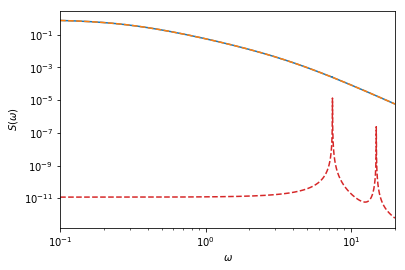

In [9]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--")

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [10]:
def log_prob(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
#     make the noise budget be dominated by the peroidic signal
#     if (gp.get_)
    return lp + gp.log_likelihood(fit_y)

ndim = len(soln.x)
nwalkers = 32
pos = soln.x + 1e-5 * np.random.randn(nwalkers, ndim)
lp = np.array(list(map(log_prob, pos)))
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = soln.x + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
pos, _, _ = sampler.run_mcmc(pos, 500)
sampler.reset()
sampler.run_mcmc(pos, 1000);

In [11]:
# mle = soln.x
mle = sampler.flatchain[np.argmax(sampler.flatlnprobability)]
gp.set_parameter_vector(mle)
mu, var = gp.predict(fit_y, t_orig, return_var=True)
std = np.sqrt(yerr_orig**2 + var)
color = "#ff7f0e"

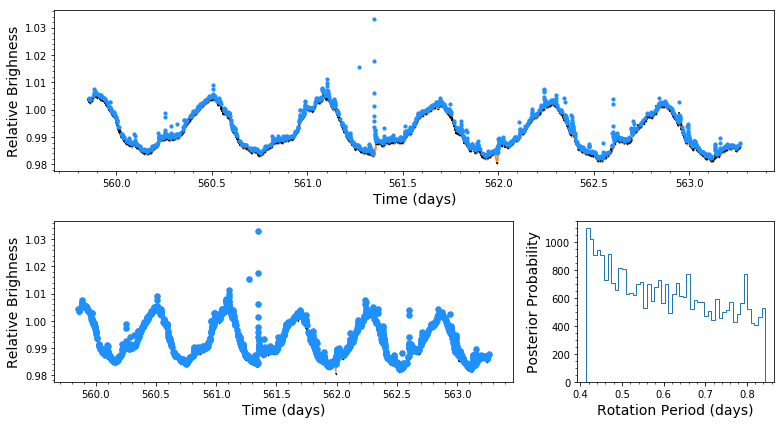

In [12]:
fig = plt.figure(figsize=[11,6])

axtop = plt.subplot2grid((2, 3), (0, 0), colspan=3, )
ax1 = plt.subplot2grid((2, 3), (1, 0), colspan=2, )
ax2 = plt.subplot2grid((2, 3), (1, 2), colspan=1, )

ax1.errorbar(t_orig, y_orig, 
             yerr=yerr_orig, fmt=".k", capsize=0,
            ms=1)
ax1.scatter(t_orig[np.in1d(y_orig,fit_y, invert=True)], 
              y_orig[np.in1d(y_orig,fit_y, invert=True)], s=30, 
              color='dodgerblue', zorder=100)
# ax1.plot(t_orig,
#               np.where(np.in1d(y_orig,fit_y, invert=True), y_orig, np.nan), ms=30, 
#               color='dodgerblue', zorder=100)

ax1.plot(t_orig, mu, color=color, alpha=0.8, lw=1)
ax1.fill_between(t_orig, mu+std*3, mu-std*3, alpha=0.2, color=color)

#ax1.set_ylim(-0.03,0.03)
#ax1.set_xlim(50,61)
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Relative Brighness', fontsize=14)


ax2.hist(np.exp(sampler.flatchain[:, 7]), 50, histtype="step")
ax2.set_xlabel('Rotation Period (days)', fontsize=14)
ax2.set_ylabel('Posterior Probability', fontsize=14)

axtop.errorbar(t_orig, y_orig, 
               yerr=yerr_orig, fmt=".k", capsize=0, 
               ms =1)

axtop.plot(t_orig, mu, color=color, alpha=1.0, lw=1)
axtop.fill_between(t_orig, mu+std*3, mu-std*3, alpha=0.5, color=color)

axtop.scatter(t_orig[np.in1d(y_orig,fit_y, invert=True)], 
              y_orig[np.in1d(y_orig,fit_y, invert=True)], s=10, 
              color='dodgerblue', zorder=100)
# axtop.plot(t_orig,
#               np.where(np.in1d(y_orig,fit_y, invert=True), y_orig, np.nan), 'o-', ms=3, 
#               color='dodgerblue', zorder=100)


#axtop.set_ylim(-0.03,0.03)
#axtop.set_xlim(0,72)
axtop.set_xlabel('Time (days)', fontsize=14)
axtop.set_ylabel('Relative Brighness', fontsize=14)

ax1.minorticks_on()
ax2.minorticks_on()
axtop.minorticks_on()

fig.tight_layout()

(35, 40)

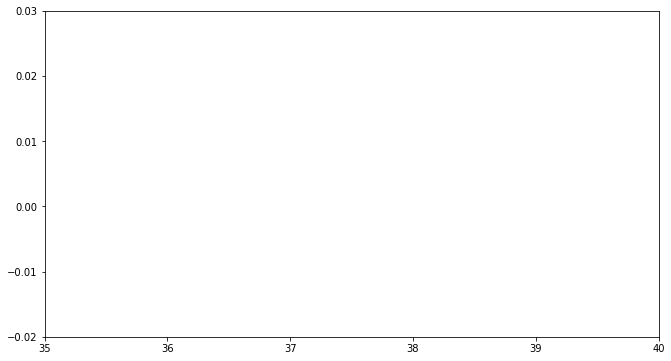

In [13]:
fig = plt.figure(figsize=[11,6])

plt.fill_between(t_orig, mu+std*3, mu-std*3, alpha=0.7, color=color, zorder=1)
plt.plot(t_orig, y_orig, '.-', zorder=0)
plt.ylim(-0.02,0.03)
plt.xlim(35,40)

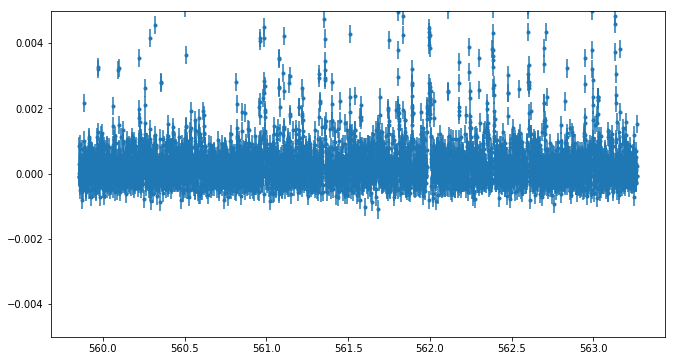

In [14]:
fig = plt.figure(figsize=[11,6])
plt.errorbar(t_orig, y_orig - mu, yerr_orig, fmt='.')
plt.ylim(-0.005,0.005)
#plt.xlim(559.5,559.75)

import pandas as pd
d = {'time': t_orig, 'flux': y_orig, 'ferr': yerr_orig, 'flux_det':y_orig - mu, 'model':mu}
df = pd.DataFrame(data=d)
df.to_csv('../data/'+name+'.csv')